In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict 
from scipy import sparse
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import warnings
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [2]:
users=pd.read_csv(r"C:\Users\Hp\Desktop\Recommended system\zee-users.dat",sep="::")
ratings = pd.read_csv(r'C:\Users\Hp\Desktop\Recommended system\zee-ratings.dat',sep="::")
movies = pd.read_csv(r'C:\Users\Hp\Desktop\Recommended system\zee-movies.dat',sep="::",encoding='latin-1')

C:\Users\Hp\AppData\Local\Temp\ipykernel_3488\818449665.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  users=pd.read_csv(r"C:\Users\Hp\Desktop\Recommended system\zee-users.dat",sep="::")
C:\Users\Hp\AppData\Local\Temp\ipykernel_3488\818449665.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv(r'C:\Users\Hp\Desktop\Recommended system\zee-ratings.dat',sep="::")
C:\Users\Hp\AppData\Local\Temp\ipykernel_3488\818449665.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are 

# Movies 

In [3]:
movies.shape

(3883, 3)

In [4]:
movies.head()

,Movie ID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
movies.columns

Index(['Movie ID', 'Title', 'Genres'], dtype='object')

In [6]:
movies.rename(columns={'Movie ID':'MovieID'},inplace=True)

In [7]:
movies1 = movies.copy()

# Ratings

In [8]:
ratings.shape

(1000209, 4)

In [9]:
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [10]:
ratings1 = ratings.copy()

# Users

In [11]:
users.shape

(6040, 5)

In [12]:
users.head(5)

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [13]:
users1=users.copy()

In [14]:
replace_age = {1:"Under18",18:"18-24",25:  "25-34",35:"35-44",45:"45-49",50:"50-55",56:"56 Above"}
replace_occupation = {0:"other", 1:"academic/educator", 2: "artist",
                             3: "clerical/admin",
                             4: "college/grad student",
                             5: "customer service",
                             6: "doctor/health care",
                             7: "executive/managerial",
                             8: "farmer",
                             9: "homemaker",
                             10: "k-12 student",
                             11: "lawyer",
                             12: "programmer",
                             13: "retired",
                             14: "sales/marketing",
                             15: "scientist",
                             16: "self-employed",
                             17: "technician/engineer",
                             18: "tradesman/craftsman",
                             19: "unemployed",
                             20: "writer"}
users['Age'] = users['Age'].replace(replace_age)
users['Occupation'] = users['Occupation'].replace(replace_occupation)

In [15]:
users

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,Under18,k-12 student,48067
1,2,M,56 Above,self-employed,70072
2,3,M,25-34,scientist,55117
3,4,M,45-49,executive/managerial,02460
4,5,M,25-34,writer,55455
...,...,...,...,...,...
6035,6036,F,25-34,scientist,32603
6036,6037,F,45-49,academic/educator,76006
6037,6038,F,56 Above,academic/educator,14706
6038,6039,F,45-49,other,01060


# Exploratory Data Analysis

# Preparing the Dataset

In [16]:
movies['Year'] = movies.Title.str.extract('(\(\d\d\d\d\))',expand=False)

#Removing the parentheses
movies['Year'] = movies.Year.str.extract('(\d\d\d\d)',expand=False)

#Removing the years from the 'Title' column
movies['Title'] = movies.Title.str.replace('(\(\d\d\d\d\))', '')

#Applying the strip function to get rid of any ending whitespace characters that may have appeared
movies['Title'] = movies['Title'].apply(lambda x : x.strip())
movies.head()

C:\Users\Hp\AppData\Local\Temp\ipykernel_3488\2645679942.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  movies['Title'] = movies.Title.str.replace('(\(\d\d\d\d\))', '')


,MovieID,Title,Genres,Year
0,1,Toy Story,Animation|Children's|Comedy,1995
1,2,Jumanji,Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama,1995
4,5,Father of the Bride Part II,Comedy,1995


In [17]:
dfmov = movies.copy()
dfmov.dropna(inplace=True)
dfmov.Genres = dfmov.Genres.str.split('|')
dfmov['Genres'] = dfmov['Genres'].apply(lambda x: [i for i in x if i!='A' and i!='D' and i!= 'F' and i!='C' and i!='M' and i!= 'W' and i!= ' '])

for i  in dfmov['Genres']:
    for j in range(len(i)):
        if i[j] == 'Ro' or i[j] == 'Rom' or i[j] == 'Roman' or i[j] == 'R' or i[j] == 'Roma':
            i[j] = 'Romance'
        elif i[j] == 'Chil' or i[j] == 'Childre' or i[j] == 'Childr' or i[j] == "Children'" or i[j] =='Children' or i[j] =='Chi':
            i[j] = "Children's"
        elif i[j] == 'Fantas' or i[j] == 'Fant':
            i[j] = 'Fantasy'
        elif i[j] == 'Dr' or i[j] == 'Dram':
            i[j] = 'Drama'
        elif i[j] == 'Documenta'or i[j] == 'Docu' or i[j] == 'Document' or i[j] == 'Documen':
            i[j] = 'Documentary'
        elif i[j] == 'Wester'or i[j] == 'We':
            i[j] = 'Western'
        elif i[j] == 'Animati':
            i[j] = 'Animation'
        elif i[j] == 'Come'or i[j] == 'Comed' or i[j] == 'Com':
            i[j] = 'Comedy'
        elif i[j] == 'Sci-F'or i[j] == 'S' or i[j] == 'Sci-' or i[j] == 'Sci':
            i[j] = 'Sci-Fi'
        elif i[j] == 'Adv'or i[j] == 'Adventu' or i[j] == 'Adventur' or i[j] == 'Advent':
            i[j] = 'Adventure'
        elif i[j] == 'Horro'or i[j] == 'Horr':
            i[j] = 'Horror'
        elif i[j] == 'Th'or i[j] == 'Thri' or i[j] == 'Thrille':
            i[j] = 'Thriller'
        elif i[j] == 'Acti':
            i[j] = 'Action'
        elif i[j] == 'Wa':
            i[j] = 'War'
        elif i[j] == 'Music':
            i[j] = 'Musical'

In [18]:
dfmov.head()

,MovieID,Title,Genres,Year
0,1,Toy Story,"[Animation, Children's, Comedy]",1995
1,2,Jumanji,"[Adventure, Children's, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama]",1995
4,5,Father of the Bride Part II,[Comedy],1995


In [19]:
df_1 = pd.merge(dfmov,ratings,how='inner',on='MovieID')
df_1.head()

,MovieID,Title,Genres,Year,UserID,Rating,Timestamp
0,1,Toy Story,"[Animation, Children's, Comedy]",1995,1,5,978824268
1,1,Toy Story,"[Animation, Children's, Comedy]",1995,6,4,978237008
2,1,Toy Story,"[Animation, Children's, Comedy]",1995,8,4,978233496
3,1,Toy Story,"[Animation, Children's, Comedy]",1995,9,5,978225952
4,1,Toy Story,"[Animation, Children's, Comedy]",1995,10,5,978226474


In [20]:
data = pd.merge(df_1,users,how='inner',on='UserID')
data.head()

,MovieID,Title,Genres,Year,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
0,1,Toy Story,"[Animation, Children's, Comedy]",1995,1,5,978824268,F,Under18,k-12 student,48067
1,48,Pocahontas,"[Animation, Children's, Musical, Romance]",1995,1,5,978824351,F,Under18,k-12 student,48067
2,150,Apollo 13,[Drama],1995,1,5,978301777,F,Under18,k-12 student,48067
3,260,Star Wars: Episode IV - A New Hope,"[Action, Adventure, Fantasy, Sci-Fi]",1977,1,4,978300760,F,Under18,k-12 student,48067
4,527,Schindler's List,"[Drama, War]",1993,1,5,978824195,F,Under18,k-12 student,48067


In [21]:
print("No. of rows: ", data.shape[0])
print("No. of columns: ", data.shape[1])

No. of rows:  1000209
No. of columns:  11


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 11 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   MovieID     1000209 non-null  int64 
 1   Title       1000209 non-null  object
 2   Genres      1000209 non-null  object
 3   Year        1000209 non-null  object
 4   UserID      1000209 non-null  int64 
 5   Rating      1000209 non-null  int64 
 6   Timestamp   1000209 non-null  int64 
 7   Gender      1000209 non-null  object
 8   Age         1000209 non-null  object
 9   Occupation  1000209 non-null  object
 10  Zip-code    1000209 non-null  object
dtypes: int64(4), object(7)
memory usage: 91.6+ MB


# Missing Values

In [23]:
missing_value = pd.DataFrame({
    'Missing Value' : data.isnull().sum(),
    'Percentage' : (data.isnull().sum()/len(data))*100
})

In [24]:
missing_value.sort_values(by='Percentage',ascending=False)

,Missing Value,Percentage
MovieID,0,0.0
Title,0,0.0
Genres,0,0.0
Year,0,0.0
UserID,0,0.0
Rating,0,0.0
Timestamp,0,0.0
Gender,0,0.0
Age,0,0.0
Occupation,0,0.0


# Feature Engineering

In [25]:
data.columns

Index(['MovieID', 'Title', 'Genres', 'Year', 'UserID', 'Rating', 'Timestamp',
       'Gender', 'Age', 'Occupation', 'Zip-code'],
      dtype='object')

In [26]:
#Change the datatype from object to date_time
data['Datatime'] = pd.to_datetime(data['Timestamp'], unit='s')

#Change the datatype from object to Integer
data['Year'] = data['Year'].astype('int32')

#Change the datatype from object to Integer
data['Rating']=data['Rating'].astype('int32')

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 12 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   MovieID     1000209 non-null  int64         
 1   Title       1000209 non-null  object        
 2   Genres      1000209 non-null  object        
 3   Year        1000209 non-null  int32         
 4   UserID      1000209 non-null  int64         
 5   Rating      1000209 non-null  int32         
 6   Timestamp   1000209 non-null  int64         
 7   Gender      1000209 non-null  object        
 8   Age         1000209 non-null  object        
 9   Occupation  1000209 non-null  object        
 10  Zip-code    1000209 non-null  object        
 11  Datatime    1000209 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(2), int64(3), object(6)
memory usage: 91.6+ MB


In [28]:
bins = [1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 2000]
labels = ['20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s']
data['ReleaseDec'] = pd.cut(data['Year'], bins=bins, labels=labels)

In [29]:
data.head()

,MovieID,Title,Genres,Year,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Datatime,ReleaseDec
0,1,Toy Story,"[Animation, Children's, Comedy]",1995,1,5,978824268,F,Under18,k-12 student,48067,2001-01-06 23:37:48,90s
1,48,Pocahontas,"[Animation, Children's, Musical, Romance]",1995,1,5,978824351,F,Under18,k-12 student,48067,2001-01-06 23:39:11,90s
2,150,Apollo 13,[Drama],1995,1,5,978301777,F,Under18,k-12 student,48067,2000-12-31 22:29:37,90s
3,260,Star Wars: Episode IV - A New Hope,"[Action, Adventure, Fantasy, Sci-Fi]",1977,1,4,978300760,F,Under18,k-12 student,48067,2000-12-31 22:12:40,70s
4,527,Schindler's List,"[Drama, War]",1993,1,5,978824195,F,Under18,k-12 student,48067,2001-01-06 23:36:35,90s


# Understanding the Dataset

In [30]:
user_ratings = data[['UserID','Rating']].groupby('UserID').mean()

Text(0, 0.5, 'Frequency')

<Figure size 800x800 with 0 Axes>

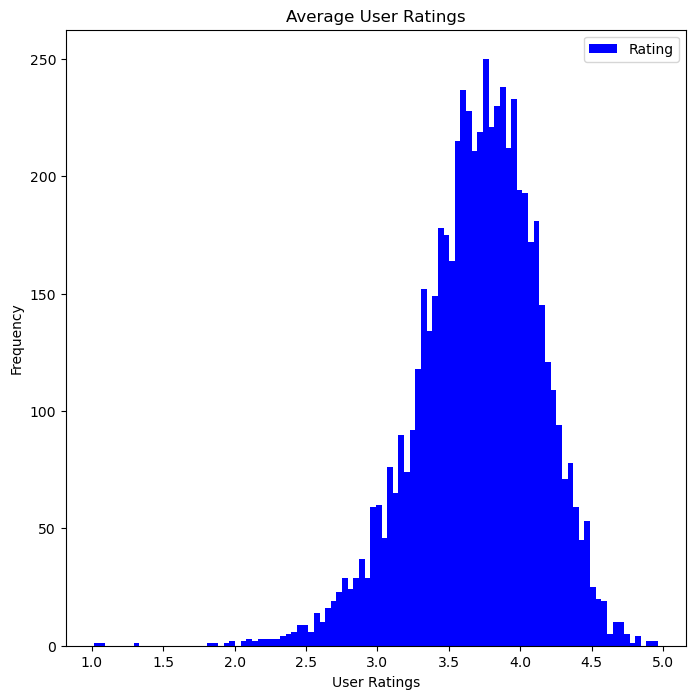

In [31]:
fig = plt.figure(figsize = (8,8))
user_ratings.plot(kind = 'hist', bins = 100, figsize = (8,8), color = 'blue')
plt.plot()
plt.xlabel('User Ratings')
plt.title('Average User Ratings')
plt.ylabel('Frequency')

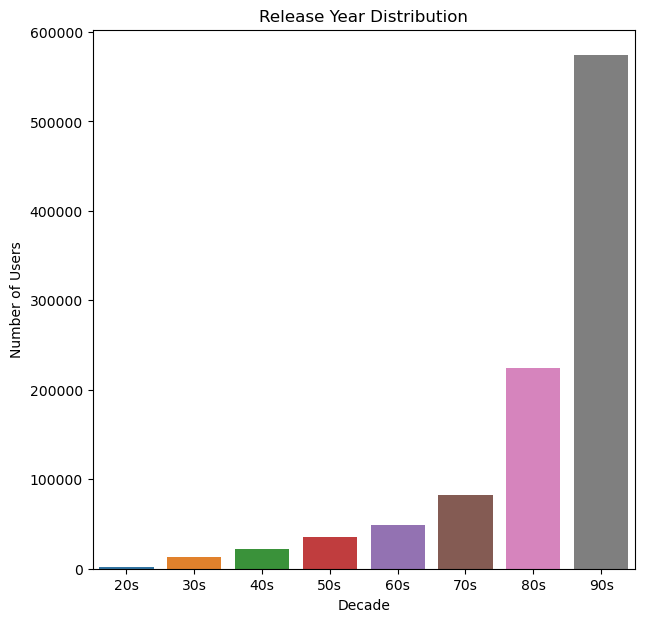

In [32]:
plt.figure(figsize=(7, 7))
sns.countplot(x='ReleaseDec', data=data)
plt.title('Release Year Distribution')
plt.xlabel('Decade')
plt.ylabel('Number of Users')
plt.show()

In [33]:
genres_df = pd.get_dummies(dfmov['Genres'].apply(pd.Series).stack()).sum(level=0)
genres_df.head()

C:\Users\Hp\AppData\Local\Temp\ipykernel_3488\3063366026.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  genres_df = pd.get_dummies(dfmov['Genres'].apply(pd.Series).stack()).sum(level=0)


,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
test = genres_df.iloc[:,0:].sum()
test=test.iloc[1:]
print(test)

Adventure       283
Animation       105
Children's      251
Comedy         1200
Crime           211
Documentary     127
Drama          1603
Fantasy          68
Film-Noir        44
Horror          343
Musical         114
Mystery         106
Romance         471
Sci-Fi          276
Thriller        492
War             143
Western          68
dtype: int64


In [35]:
len(test)

17

In [36]:
print(type(pd.to_numeric(test)))
print(type(test.to_numpy().reshape(17,)[0]))
# genre_sum = np.hstack((np.asarray(genre_list).reshape(18,1), test.to_numpy().reshape(18,)))
# genre_sum[:,1] = genre_sum[:,1].astype('int64')
test2 = test.to_numpy().reshape(17,)

<class 'pandas.core.series.Series'>
<class 'numpy.int64'>


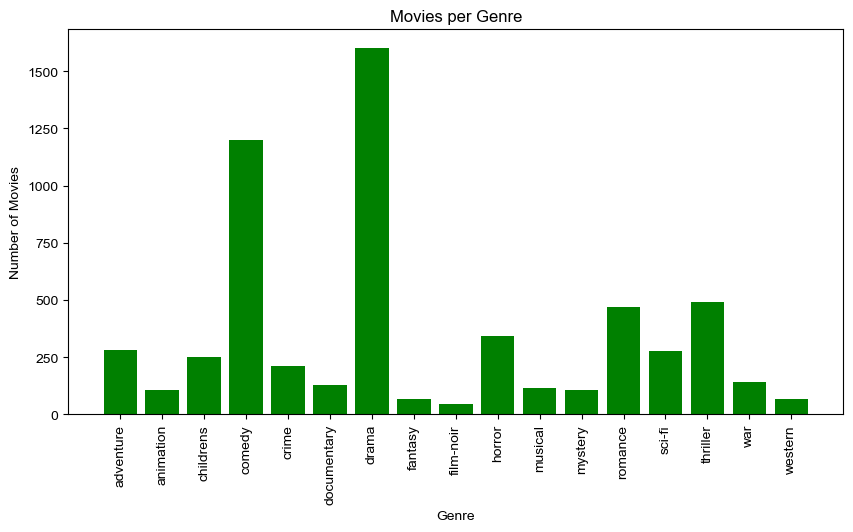

In [37]:
genre_list=['adventure','animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama','fantasy', 'film-noir', 'horror', 'musical', 'mystery', 'romance', 'sci-fi','thriller', 'war', 'western']
x = np.arange(17)
plt.figure(figsize = (10,5))
plt.bar(x, test2, color = 'g')
plt.xticks(x, genre_list, rotation = 'vertical')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Movies per Genre')
sns.set(font_scale=1.5)
plt.show()

# Distribution by Age -

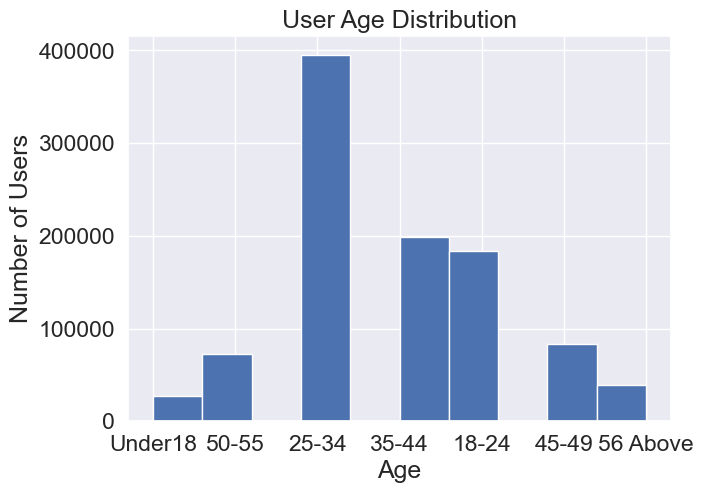

In [38]:
data['Age'].hist(figsize=(7, 5))
plt.title('User Age Distribution')
plt.xlabel('Age')
plt.ylabel('Number of Users')
plt.show()

# Distribution by Gender -

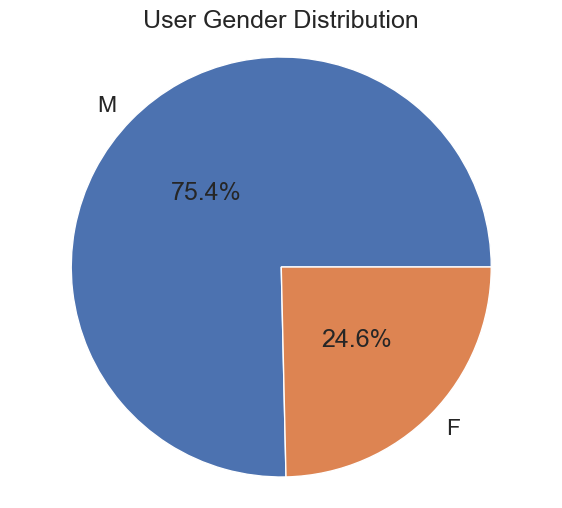

In [39]:
x = data['Gender'].value_counts().values
plt.figure(figsize=(7, 6))
plt.pie(x, center=(0, 0), radius=1.5, labels=['M','F'], autopct='%1.1f%%', pctdistance=0.5)
plt.title('User Gender Distribution')
plt.axis('equal')
plt.show()

# Distribution by Occupation 

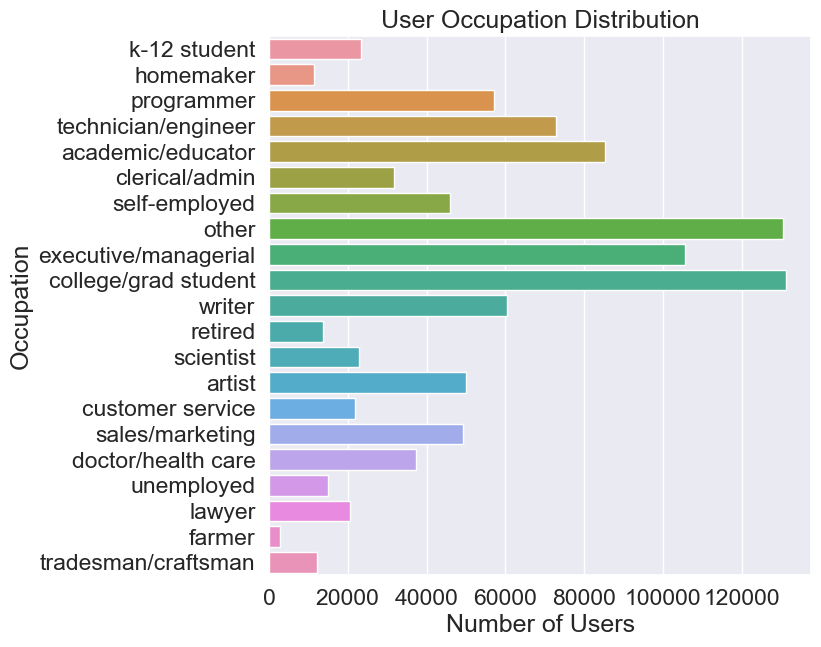

In [40]:
plt.figure(figsize=(7, 7))
sns.countplot(y='Occupation', data=data)
plt.title('User Occupation Distribution')
plt.xlabel('Number of Users')
plt.ylabel('Occupation')
plt.show()

In [41]:
movies_rating_count = data.groupby(by=['Title'])['Rating'].count().reset_index()[['Title','Rating']]
movies_rating_count.rename(columns = {'Rating' : 'totalRatingCount'},inplace=True)
movies_rating_count.head()

,Title,totalRatingCount
0,"$1,000,000 Duck",37
1,'Night Mother,70
2,'Til There Was You,52
3,"'burbs, The",303
4,...And Justice for All,199


In [42]:
top10_movies=movies_rating_count[['Title','totalRatingCount']].sort_values(by='totalRatingCount',ascending=False).head(10)
top10_movies

,Title,totalRatingCount
126,American Beauty,3428
3117,Star Wars: Episode IV - A New Hope,2991
3118,Star Wars: Episode V - The Empire Strikes Back,2990
3119,Star Wars: Episode VI - Return of the Jedi,2883
1773,Jurassic Park,2672
2860,Saving Private Ryan,2653
3257,Terminator 2: Judgment Day,2649
2089,"Matrix, The",2590
257,Back to the Future,2583
2954,"Silence of the Lambs, The",2578


Text(0, 0.5, 'User Rating count')

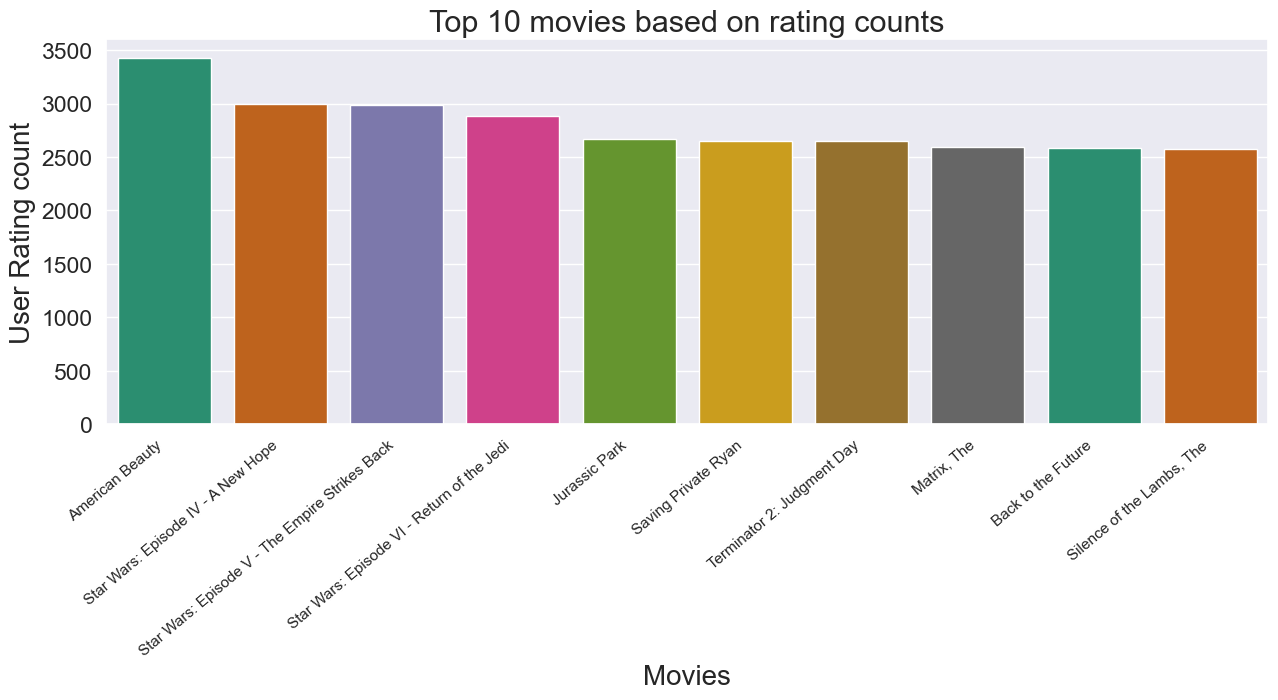

In [43]:
plt.figure(figsize=(15,5))
ax=sns.barplot(x="Title", y="totalRatingCount", data=top10_movies, palette="Dark2")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11, rotation=40, ha="right")
ax.set_title('Top 10 movies based on rating counts',fontsize = 22)
ax.set_xlabel('Movies',fontsize = 20) 
ax.set_ylabel('User Rating count', fontsize = 20)

# Recommendations systems

In [44]:
matrix = pd.pivot_table(data,index='UserID',columns='Title',values='Rating',aggfunc='mean')

# Imputing 'NaN' values with Zero rating 
matrix.fillna(0,inplace=True)
matrix.shape

(6040, 3664)

In [45]:
matrix.head(10)

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
# Checking data sparsity
n_users = data['UserID'].nunique()
n_movies = data['MovieID'].nunique()
sparsity = round(1.0 - data.shape[0] / float( n_users * n_movies), 3)
print('The sparsity level of dataset is ' +  str(sparsity * 100) + '%')

The sparsity level of dataset is 95.5%


# Pearson Correlation

In [47]:
data[data['Title']=='Home Alone']

,MovieID,Title,Genres,Year,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Datatime,ReleaseDec
416,586,Home Alone,"[Children's, Comedy]",1990,10,3,978228747,F,35-44,academic/educator,95370,2000-12-31 02:12:27,90s
825,586,Home Alone,"[Children's, Comedy]",1990,18,4,978155233,F,18-24,clerical/admin,95825,2000-12-30 05:47:13,90s
1749,586,Home Alone,"[Children's, Comedy]",1990,26,2,978140049,M,25-34,executive/managerial,23112,2000-12-30 01:34:09,90s
2712,586,Home Alone,"[Children's, Comedy]",1990,38,4,978046369,F,18-24,college/grad student,02215,2000-12-28 23:32:49,90s
3024,586,Home Alone,"[Children's, Comedy]",1990,45,3,977991192,F,45-49,self-employed,94110,2000-12-28 08:13:12,90s
...,...,...,...,...,...,...,...,...,...,...,...,...,...
979296,586,Home Alone,"[Children's, Comedy]",1990,4273,5,989118624,M,45-49,retired,30030,2001-05-06 03:10:24,90s
981924,586,Home Alone,"[Children's, Comedy]",1990,3385,3,967564715,F,25-34,homemaker,32212,2000-08-29 15:58:35,90s
985457,586,Home Alone,"[Children's, Comedy]",1990,3633,4,966526025,M,35-44,tradesman/craftsman,60441,2000-08-17 15:27:05,90s
994748,586,Home Alone,"[Children's, Comedy]",1990,4846,3,962834091,F,25-34,artist,90066,2000-07-05 21:54:51,90s


In [48]:
#movie_name = input("Enter a movie name: ")
movie_name = 'Home Alone'
# Taking the ratings of that movie
movie_rating = matrix[movie_name]
movie_rating

UserID
1       0.0
2       0.0
3       0.0
4       0.0
5       0.0
       ... 
6036    0.0
6037    0.0
6038    0.0
6039    0.0
6040    0.0
Name: Home Alone, Length: 6040, dtype: float64

In [49]:
similar_movies = matrix.corrwith(movie_rating)
#Finding similar movies

sim_df = pd.DataFrame(similar_movies, columns=['Correlation'])
# Sorting the values based on correlation
sim_df.sort_values('Correlation', ascending=False,inplace=True)

#Top 5 correlated movies.
sim_df.iloc[1:, :].head()

,Correlation
Title,
Home Alone 2: Lost in New York,0.547203
Mrs. Doubtfire,0.468281
Liar Liar,0.455967
"Mighty Ducks, The",0.446273
Sister Act,0.444612


# Cosine Similarty

In [50]:
item_sim = cosine_similarity(matrix.T)
item_sim

array([[1.        , 0.07235746, 0.03701053, ..., 0.        , 0.12024178,
        0.02700277],
       [0.07235746, 1.        , 0.11528952, ..., 0.        , 0.        ,
        0.07780705],
       [0.03701053, 0.11528952, 1.        , ..., 0.        , 0.04752635,
        0.0632837 ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.04564448],
       [0.12024178, 0.        , 0.04752635, ..., 0.        , 1.        ,
        0.04433508],
       [0.02700277, 0.07780705, 0.0632837 , ..., 0.04564448, 0.04433508,
        1.        ]])

In [51]:
item_sim_matrix = pd.DataFrame(item_sim, index=matrix.columns, columns=matrix.columns)
item_sim_matrix.head()

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
Title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck",1.000000,0.072357,0.037011,0.079291,0.060838,0.00000,0.058619,0.189843,0.094785,0.058418,...,0.038725,0.076474,0.000000,0.044074,0.0,0.045280,0.039395,0.000000,0.120242,0.027003
'Night Mother,0.072357,1.000000,0.115290,0.115545,0.159526,0.00000,0.076798,0.137135,0.111413,0.046135,...,0.053010,0.087828,0.063758,0.135962,0.0,0.091150,0.074787,0.000000,0.000000,0.077807
'Til There Was You,0.037011,0.115290,1.000000,0.098756,0.066301,0.08025,0.127895,0.128523,0.079115,0.066598,...,0.029200,0.062893,0.000000,0.079187,0.0,0.022594,0.079261,0.000000,0.047526,0.063284
"'burbs, The",0.079291,0.115545,0.098756,1.000000,0.143620,0.00000,0.192191,0.250140,0.170719,0.197808,...,0.113386,0.207897,0.019962,0.138064,0.0,0.055704,0.161174,0.000000,0.033567,0.110525
...And Justice for All,0.060838,0.159526,0.066301,0.143620,1.000000,0.00000,0.075093,0.178928,0.205486,0.122431,...,0.089998,0.153006,0.067009,0.109029,0.0,0.086080,0.110867,0.074317,0.000000,0.111040


In [52]:
user_sim = cosine_similarity(matrix)
user_sim

array([[1.        , 0.09638153, 0.12060981, ..., 0.        , 0.17460369,
        0.13359025],
       [0.09638153, 1.        , 0.1514786 , ..., 0.06611767, 0.0664575 ,
        0.21827563],
       [0.12060981, 0.1514786 , 1.        , ..., 0.12023352, 0.09467506,
        0.13314404],
       ...,
       [0.        , 0.06611767, 0.12023352, ..., 1.        , 0.16171426,
        0.09930008],
       [0.17460369, 0.0664575 , 0.09467506, ..., 0.16171426, 1.        ,
        0.22833237],
       [0.13359025, 0.21827563, 0.13314404, ..., 0.09930008, 0.22833237,
        1.        ]])

In [53]:
user_sim_matrix = pd.DataFrame(user_sim, index=matrix.index, columns=matrix.index)
user_sim_matrix.head()

UserID,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.096382,0.120610,0.132455,0.090158,0.179222,0.059678,0.138241,0.226148,0.254736,...,0.170588,0.082006,0.090961,0.033663,0.114877,0.186957,0.136233,0.000000,0.174604,0.133590
2,0.096382,1.000000,0.151479,0.171176,0.114394,0.100865,0.305787,0.211120,0.190198,0.227745,...,0.112503,0.091222,0.268565,0.014286,0.183384,0.229011,0.206660,0.066118,0.066457,0.218276
3,0.120610,0.151479,1.000000,0.151227,0.062907,0.074603,0.138332,0.077656,0.126457,0.214487,...,0.092960,0.125864,0.161507,0.000000,0.097308,0.143747,0.107945,0.120234,0.094675,0.133144
4,0.132455,0.171176,0.151227,1.000000,0.045094,0.013529,0.130339,0.100856,0.093651,0.121208,...,0.163629,0.093041,0.382803,0.000000,0.082097,0.171158,0.127703,0.062907,0.064634,0.137968
5,0.090158,0.114394,0.062907,0.045094,1.000000,0.047449,0.126257,0.220817,0.261330,0.117508,...,0.100652,0.035732,0.065278,0.054151,0.179083,0.294354,0.173009,0.020459,0.027689,0.241437


In [54]:
model_knn = NearestNeighbors(metric='cosine')
model_knn.fit(matrix.T)

NearestNeighbors(metric='cosine')

In [55]:
distances, indices = model_knn.kneighbors(matrix.T,n_neighbors=6)

In [56]:
result = pd.DataFrame(indices, columns=['Title1','Title2','Title3', 'Title4', 'Title5', 'Title6'])

result.head()

,Title1,Title2,Title3,Title4,Title5,Title6
0,0,737,417,287,585,3266
1,1,809,73,2181,3054,3390
2,2,1637,2544,3340,2603,2012
3,3,1467,2183,1318,1054,3533
4,4,26,728,897,496,947


In [57]:
result2 = result.copy()
for i in range(1, 7):
    mov = pd.DataFrame(matrix.T.index).reset_index()
    mov = mov.rename(columns={'index':f'Title{i}'})
    result2 = pd.merge(result2, mov, on=[f'Title{i}'], how='left')
    result2 = result2.drop(f'Title{i}', axis=1)
    result2 = result2.rename(columns={'Title':f'Title{i}'})
result2.head()

,Title1,Title2,Title3,Title4,Title5,Title6
0,"$1,000,000 Duck","Computer Wore Tennis Shoes, The",Blackbeard's Ghost,"Barefoot Executive, The",Candleshoe,That Darn Cat!
1,'Night Mother,"Cry in the Dark, A",Agnes of God,Mommie Dearest,Sophie's Choice,"Trip to Bountiful, The"
2,'Til There Was You,If Lucy Fell,Picture Perfect,To Gillian on Her 37th Birthday,Practical Magic,Mad Love
3,"'burbs, The",Harry and the Hendersons,"Money Pit, The",Ghostbusters II,European Vacation,Weekend at Bernie's
4,...And Justice for All,52 Pick-Up,Coma,Deliverance,"Boys from Brazil, The",Dog Day Afternoon


In [58]:
movie_name = 'Liar Liar'
result2.loc[result2['Title1']==movie_name] 

,Title1,Title2,Title3,Title4,Title5,Title6
1899,Liar Liar,Mrs. Doubtfire,Ace Ventura: Pet Detective,Dumb & Dumber,Home Alone,Wayne's World


In [59]:
rm = data.pivot(index= 'UserID', columns= 'MovieID', values = 'Rating').fillna(0)
rm.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# User-Based Approach

In [60]:
#Taking 6 movies names in random
mov_name = ['Hamlet', 'Dumb & Dumber', 'Ace Ventura: Pet Detective', 'Home Alone','Robin Hood','It Happened One Night']

In [61]:
#Finding the MovieID's for the above movies
mov_id=[]
for mov in mov_name:
    id=data[data['Title']==mov]['MovieID'].iloc[0]
    mov_id.append(id)

In [62]:
#mov_rating = list(map(int, input("Rate these movies respectively: ").split())) 
mov_rating = [5,3,2,1,4,3]#Give the random user rating for the movies

In [63]:
user_choices = pd.DataFrame({'MovieID': mov_id, 'Title': mov_name, 'Rating': mov_rating})
user_choices.sort_values(by='MovieID') #User choices

,MovieID,Title,Rating
1,231,Dumb & Dumber,3
2,344,Ace Ventura: Pet Detective,2
3,586,Home Alone,1
5,905,It Happened One Night,3
0,1411,Hamlet,5
4,3034,Robin Hood,4


In [64]:
other_users = data[data['MovieID'].isin(user_choices['MovieID'].values)] #Finding the similar users who watched same movies
other_users = other_users[['UserID', 'MovieID', 'Rating']]
other_users['UserID'].nunique()

1810

In [65]:
common_movies = other_users.groupby(['UserID']) #Grouping the data based on User who watched the common movies
common_movies = sorted(common_movies, key=lambda x: len(x[1]), reverse=True) #Soring the data so that who watched more number of common movies comes at the top.
common_movies[0] 

C:\Users\Hp\AppData\Local\Temp\ipykernel_3488\533956468.py:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  common_movies = sorted(common_movies, key=lambda x: len(x[1]), reverse=True) #Soring the data so that who watched more number of common movies comes at the top.


(1605,
         UserID  MovieID  Rating
 154727    1605      231       2
 154774    1605      344       3
 154848    1605      586       3
 154904    1605      905       4
 155047    1605     1411       3
 155441    1605     3034       4)

In [66]:
top_users = common_movies[:100] #Taking top 100 users who watched same movies as in user choices.

In [67]:
#Calculating pearson correlation
pearson_corr = {}

for user_id, movies in top_users:
    movies = movies.sort_values(by='MovieID') 
    movie_list = movies['MovieID'].values 

    new_user_ratings = user_choices[user_choices['MovieID'].isin(movie_list)]['Rating'].values
    user_ratings = movies[movies['MovieID'].isin(movie_list)]['Rating'].values 
    
    corr = pearsonr(new_user_ratings, user_ratings) 
    pearson_corr[user_id] = corr[0] 

C:\Users\Hp\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [68]:
pearson_df = pd.DataFrame(columns=['UserID', 'Similarity Index'], data=pearson_corr.items()) # Creating a dataframe for UserId and Correlation values as 'Similarity Index'
pearson_df = pearson_df.sort_values(by='Similarity Index', ascending=False)[:10] #Showing for top 10 Users
pearson_df

,UserID,Similarity Index
98,3224,0.943880
7,424,0.943456
73,1943,0.923381
35,5795,0.880705
43,524,0.870388
53,1019,0.870388
82,2507,0.852803
47,714,0.774597
57,1120,0.774597
42,438,0.774597


In [69]:
users_rating = pearson_df.merge(data, on='UserID', how='inner') #Merging the original data with pearson correlation values
users_rating['Weighted Rating'] = users_rating['Rating'] * users_rating['Similarity Index'] # Calculating the Weighed rating for each user and movie
users_rating = users_rating[['UserID', 'MovieID', 'Rating', 'Similarity Index', 'Weighted Rating']]
users_rating

,UserID,MovieID,Rating,Similarity Index,Weighted Rating
0,3224,2,3,0.943880,2.831639
1,3224,3,4,0.943880,3.775519
2,3224,6,4,0.943880,3.775519
3,3224,7,3,0.943880,2.831639
4,3224,10,3,0.943880,2.831639
...,...,...,...,...,...
8855,438,3869,4,0.774597,3.098387
8856,438,3877,2,0.774597,1.549193
8857,438,3911,4,0.774597,3.098387
8858,438,3946,1,0.774597,0.774597


In [70]:
# Calculate sum of similarity index and weighted rating for each movie
grouped_ratings = users_rating.groupby('MovieID').sum()[['Similarity Index', 'Weighted Rating']]

recommend_movies = pd.DataFrame()

# Add average recommendation score. 
# We're calculating average recommendation score by dividing the Weighted Rating by the Similarity Index.
recommend_movies['avg_reccomend_score'] = grouped_ratings['Weighted Rating']/grouped_ratings['Similarity Index']
recommend_movies['MovieID'] = grouped_ratings.index
recommend_movies = recommend_movies.reset_index(drop=True)

# Select movies with the highest score i.e. 5
recommend_movies = recommend_movies[(recommend_movies['avg_reccomend_score'] == 5)]

In [71]:
recommendations = data[data['MovieID'].isin(recommend_movies['MovieID'])][['MovieID', 'Title']].sample(10)
recommendations 

,MovieID,Title
918538,1546,Schizopolis
475231,1643,"Mrs. Brown (Her Majesty, Mrs. Brown)"
708079,1250,"Bridge on the River Kwai, The"
201726,3720,Sunshine
22975,3095,"Grapes of Wrath, The"
357299,265,Like Water for Chocolate (Como agua para choco...
420911,1047,"Long Kiss Goodnight, The"
138611,3556,"Virgin Suicides, The"
991495,3036,Quest for Fire
318932,1199,Brazil


# Regression Based Rec Sys

In [72]:
from sklearn.preprocessing import StandardScaler

In [73]:
movies1.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [74]:
ratings1.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [75]:
users1.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [76]:
m = pd.concat([movies1['MovieID'],genres_df.iloc[:,1:]],axis=1)
m.head()

,MovieID,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [77]:
from datetime import datetime
r = ratings1.copy()
r['Timestamp']=r['Timestamp'].astype('int32')
r['Rating']=r['Rating'].astype('int32')
r['hour'] = r['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).hour)
r.head()

,UserID,MovieID,Rating,Timestamp,hour
0,1,1193,5,978300760,3
1,1,661,3,978302109,4
2,1,914,3,978301968,4
3,1,3408,4,978300275,3
4,1,2355,5,978824291,5


In [78]:
users2 = users1.merge(r.groupby('UserID').Rating.mean().reset_index(), on='UserID')
users2 = users2.merge(r.groupby('UserID').hour.mean().reset_index(), on='UserID')
users2.head(2)

,UserID,Gender,Age,Occupation,Zip-code,Rating,hour
0,1,F,1,10,48067,4.188679,3.792453
1,2,M,56,16,70072,3.713178,2.968992


In [79]:
u = users2[['UserID','Age', 'Rating', 'hour']].copy()
u = u.set_index('UserID')
u .columns = ['Age', 'User_avg_rating', 'hour']

scaler = StandardScaler()
u = pd.DataFrame(scaler.fit_transform(u), columns=u.columns, index=u.index)
u.head(2)

,Age,User_avg_rating,hour
UserID,,,
1,-2.298525,1.131261,-0.909947
2,1.966729,0.024380,-1.037952


In [80]:
df_cat = users2[['Gender','Occupation']]
df_cat['Gender']=pd.get_dummies(df_cat['Gender'], columns=['Gender'],drop_first=True)
df_cat = pd.concat([users['UserID'],df_cat],axis=1)
df_cat.head()

C:\Users\Hp\AppData\Local\Temp\ipykernel_3488\2292319686.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat['Gender']=pd.get_dummies(df_cat['Gender'], columns=['Gender'],drop_first=True)


,UserID,Gender,Occupation
0,1,0,10
1,2,1,16
2,3,1,15
3,4,1,7
4,5,1,20


In [81]:
X = ratings[['MovieID', 'UserID', 'Rating']].copy()
X = X.merge(u.reset_index(), on='UserID', how='right')
X = X.merge(m.reset_index(), on='MovieID', how='right')
X = X.merge(df_cat, on='UserID', how='right')
X.drop(columns=['index'], axis=1, inplace=True)
X.dropna(inplace=True)
X.reset_index(inplace=True,drop=True)
X1=X.copy()
X.head()

,MovieID,UserID,Rating,Age,User_avg_rating,hour,Adventure,Animation,Children's,Comedy,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Gender,Occupation
0,1,1.0,5.0,-2.298525,1.131261,-0.909947,0,1,1,1,...,0,0,0,0,0,0,0,0,0,10
1,48,1.0,5.0,-2.298525,1.131261,-0.909947,0,1,1,0,...,0,1,0,1,0,0,0,0,0,10
2,150,1.0,5.0,-2.298525,1.131261,-0.909947,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
3,260,1.0,4.0,-2.298525,1.131261,-0.909947,1,0,0,0,...,0,0,0,0,1,0,0,0,0,10
4,527,1.0,5.0,-2.298525,1.131261,-0.909947,0,0,0,0,...,0,0,0,0,0,0,1,0,0,10


In [82]:
X = X.drop(columns = ['MovieID', 'UserID'])
y = X.pop('Rating')

In [83]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [84]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [85]:
rmse = mean_squared_error(y_test, y_pred, squared=False) # calculating rmse value
print('Root Mean Squared Error: {:.3f}'.format(rmse))

Root Mean Squared Error: 1.011


In [86]:
mape =  mean_absolute_percentage_error(y_test, y_pred) #calculating mape value
print('Mean Absolute Percentage Error: {:.3f}'.format(mape))

Mean Absolute Percentage Error: 0.326


# Ensemble Recommender System

In [87]:
X1.head()

,MovieID,UserID,Rating,Age,User_avg_rating,hour,Adventure,Animation,Children's,Comedy,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Gender,Occupation
0,1,1.0,5.0,-2.298525,1.131261,-0.909947,0,1,1,1,...,0,0,0,0,0,0,0,0,0,10
1,48,1.0,5.0,-2.298525,1.131261,-0.909947,0,1,1,0,...,0,1,0,1,0,0,0,0,0,10
2,150,1.0,5.0,-2.298525,1.131261,-0.909947,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
3,260,1.0,4.0,-2.298525,1.131261,-0.909947,1,0,0,0,...,0,0,0,0,1,0,0,0,0,10
4,527,1.0,5.0,-2.298525,1.131261,-0.909947,0,0,0,0,...,0,0,0,0,0,0,1,0,0,10


In [88]:
y = X1.pop('Rating')

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=10)

In [90]:
X_train1 = X_train[['MovieID', 'UserID']].copy()
X_train = X_train.drop(columns = ['MovieID', 'UserID'])
user_item_train=pd.concat([X_train1,y_train],axis=1)

In [91]:
X_test1 = X_test[['MovieID', 'UserID']].copy()
X_test = X_test.drop(columns = ['MovieID', 'UserID'])
user_item_test=pd.concat([X_test1,y_test],axis=1)

In [92]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
y_pred_reg = model.predict(X_test)

In [93]:
user_item_test.columns = ['UserId', 'ItemId', 'Rating']  # Lib requires specific column names
user_item_test.head(2)

,UserId,ItemId,Rating
511275,858,3154.0,2.0
467574,3863,2881.0,3.0
